In [6]:
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

folder = os.path.join(os.getcwd(),"..","data")

extension = '.jpg'

names = [name for name in os.listdir(folder) if name.endswith(extension)]
filenames = [os.path.join(folder,name) for name in names]
images = [cv2.cvtColor(cv2.imread(filename, cv2.IMREAD_UNCHANGED), cv2.COLOR_BGR2GRAY) for filename in filenames]

data = []
meta = []

thresh = 100
maxval = 200
mode = cv2.THRESH_BINARY_INV

epsilon = 0.1
kernel = np.ones((80,80),np.uint8)

for k,image in enumerate(images):
    
    name = names[k]

    i8 = image.copy() # Mono8

    rc,it = cv2.threshold(
        255-i8,
        thresh=thresh,
        maxval=maxval,
        type=mode
        )
    it = cv2.dilate(it, kernel=kernel, iterations=1)
    cc,h = cv2.findContours(it,1,2)

    aa = []
    ca = []
    for c in cc:
        a = cv2.approxPolyDP(c, epsilon=epsilon*cv2.arcLength(c,True), closed=True)
        if len(a) == 4:

            r = cv2.minAreaRect(c)
            b = cv2.boxPoints(r)
            b = np.intp(b)
            
            aa.append(b)
            ca.append(cv2.contourArea(c))
    
    ca = np.array(ca)    
    if len(a)>0:

        ic = cv2.cvtColor(i8,cv2.COLOR_GRAY2RGB)
        
        index = np.argmax(ca)        

        lva = cv2.Laplacian(i8, cv2.CV_64F).var()
        
        meta.append(dict(
            name=name,
            area=ca[index],
            blur=lva,
            box=aa[index],
            avg=np.average(aa[index],axis=0)
            ))

        a = aa[index]        
        cv2.drawContours(
            image=ic,
            contours=[a],
            contourIdx=0,
            color=(255,0,0),
            thickness=25)
    
    data.append(dict(
        ic=ic,
        i8=i8,
        it=it
        ))

data = np.array(data)
N = data.shape[0]

meta = pd.DataFrame(meta)
index = meta.index.to_list()

data = data[index]


In [5]:
x = meta['step'].to_numpy()
y = meta['area'].to_numpy()

w = 4
s = np.lib.stride_tricks.sliding_window_view(y, window_shape=w)

f = np.array([np.polyfit(range(w), s[j,], 1) for j in range(s.shape[0])]).ravel().reshape(-1,2)

m = f[:,0]
b = f[:,1]

#i = np.argwhere(np.abs(m) >.01)
#m = m[i]
#b = b[i]

#l = len(i)
#x = range(l)

x_ = m
y_ = m

y_.shape,x_.shape

((37,), (37,))

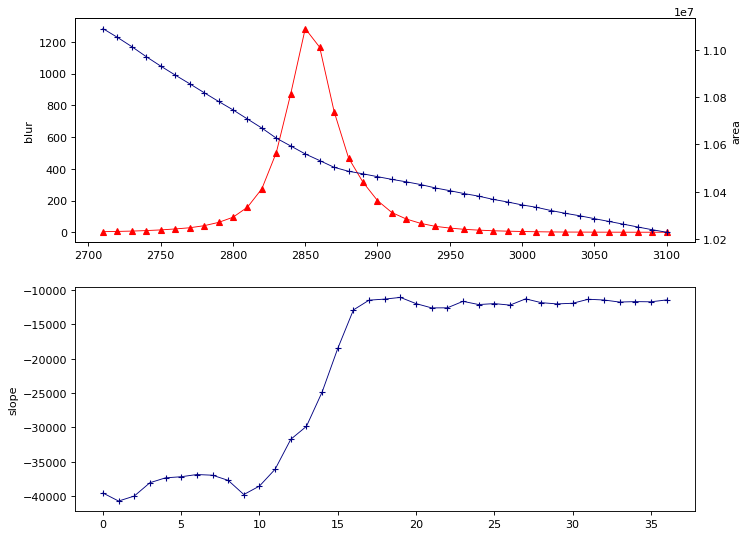

In [6]:
ncols = 1
nrows = 2

w = 10
h = nrows*w/2.5

dpi = 80
plt.rcParams["figure.dpi"] = dpi
plt.rcParams['figure.figsize'] = [w,h]

fig, ax = plt.subplots(nrows=nrows,ncols=ncols)

ax[0].plot(meta['step'],meta['blur'],'^-',lw=0.8,c='red',label='blur(step)')
ax[0].set_ylabel('blur')

ax02 = ax[0].twinx()
ax02.plot(meta['step'],meta['area'],'+-',lw=0.8,c='navy',label='area(step)')
ax02.set_ylabel('area')

ax[1].plot(y_,'+-',lw=0.8,c='navy',label='')
ax[1].set_ylabel('slope')

plt.show()
plt.close()

In [ ]:
ncols = 1
nrows = 1

w = 10
h = w/2

dpi = 80
plt.rcParams["figure.dpi"] = dpi
plt.rcParams['figure.figsize'] = [w,h]

fig, ax = plt.subplots(nrows=nrows,ncols=ncols)

xy = np.vstack(meta['avg'].to_numpy())

ax.plot(xy[:,0],xy[:,1],'^',lw=0.8,c='red',label='blur(step)')
ax.set_ylabel('')

for i,p in enumerate(xy):
    ax.annotate(f"{meta.loc[i,'blur']:.2f}",xy=p,rotation=0)

plt.show()
plt.close()

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

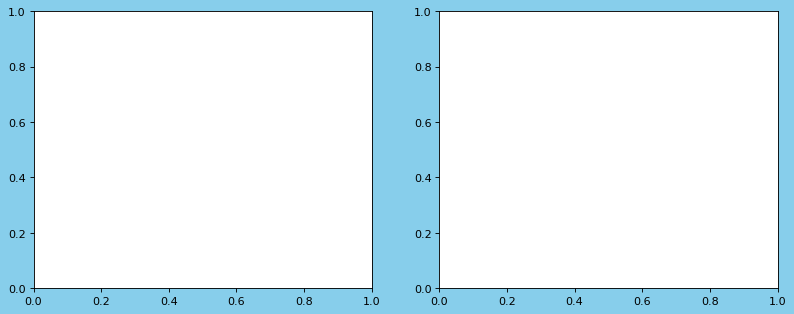

In [7]:

ncols = 2
nrows = N

shape = images[0].shape
f = shape[1]/shape[0]

w = 12
h = w*nrows / 2 / f

dpi = 80
plt.rcParams["figure.dpi"] = dpi
plt.rcParams['figure.figsize'] = [w,h]

fig, ax = plt.subplots(nrows=nrows,ncols=ncols)

fig.set_facecolor('skyblue')

for j in range(N):
    
    ax[j,0].imshow(data[j]['ic'])
    ax[j,1].imshow(data[j]['it'], cmap=plt.cm.gray)

    ax[j,0].set_title(f"{meta.loc[index[j],'step']}, {meta.loc[index[j],'blur']:.3f}, {meta.loc[index[j],'area']}", 
                      x=0, ha="left")   
    
for a_ in ax.ravel():
    a_.set_axis_off()

#plt.tight_layout()
plt.show()
plt.close()
